In [1]:
import numpy as np
from matplotlib import pyplot as plt
import utils_hugo as ut
import seaborn as sns

# Loading the data

In [2]:
n_samples = 20
seed=0

In [3]:
bids_dir = "/Users/hugofluhr/DATA/ds003505/"
#subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', ]
subjects = ['sub-{:02d}'.format(i) for i in range(1,21) if i!=5] # subject 5 data was discarded because poor quality
epochs_multi, y_multi = ut.multiple_subjects_epochs(bids_dir=bids_dir, subjects= subjects, tmin=-0.1, tmax=0.5, apply_proj=False, apply_baseline=True)
X_red, y_red, S_red = ut.aggregate_epochs(epochs_multi,y_multi, subjects)
del epochs_multi, y_multi
#X_red, y_red, S_red = ut.reduce_trials(X, y, S, n_samples=n_samples, seed=seed)
#del X, y, S

In [4]:
X_red.shape

(10983, 128, 151)

# Compute Adjacencies

In [5]:
A = ut.compute_graphs_multi(X_red, ut.corr_coef_graph, threshold=False)
del X_red

  0%|          | 0/10983 [00:00<?, ?it/s]

In [6]:
A.shape

(10983, 128, 128)

# Graph characterization

- number of nodes and edges/density
- degree distribution (+ moments?)
- path matrices not informative
- diameter
- CC
- assignment 1b : simulate network models to compare to

## Example graphs and variation between subjects and trial types

1


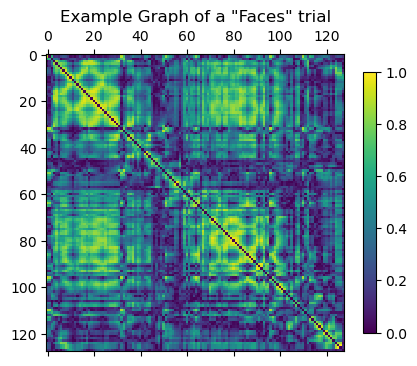

In [7]:
# example graph for Faces trial
a = A[0]
print(y_red[0])
plt.matshow(a, vmax=1)
plt.title('Example Graph of a "Faces" trial')
plt.colorbar(shrink=.7)
plt.show()

0


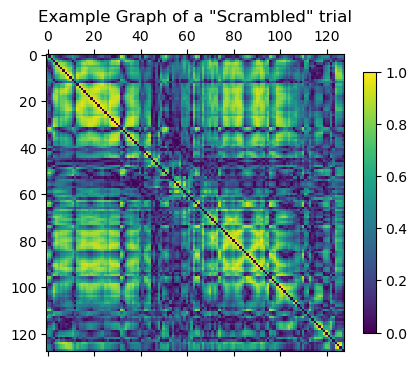

In [8]:
# example graph for Scrambled trial
ind = 2
print(y_red[ind])
plt.matshow(A[ind], vmax=1)
plt.title('Example Graph of a "Scrambled" trial')
plt.colorbar(shrink=.7)
plt.show()

## Edge weight vs electrode distance

In [9]:
A_thresh, thresholds = ut.threshold_graphs(A, 0.2)

In [10]:
print('thresholds = {:.2f}±{:.2f}'.format(np.mean(thresholds), np.std(thresholds)))

thresholds = 0.63±0.09


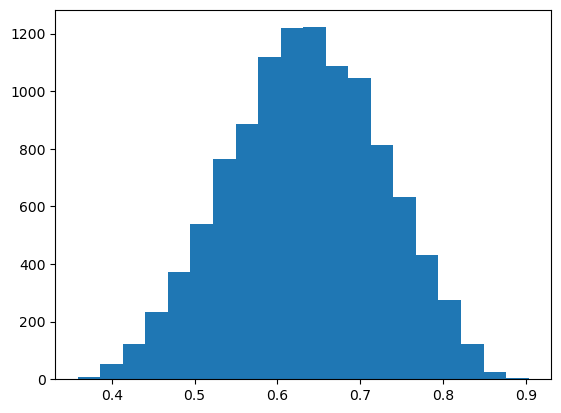

In [11]:
plt.hist(thresholds, bins=20);

In [12]:
dist_geodesic = ut.electrode_distances_geodesic()

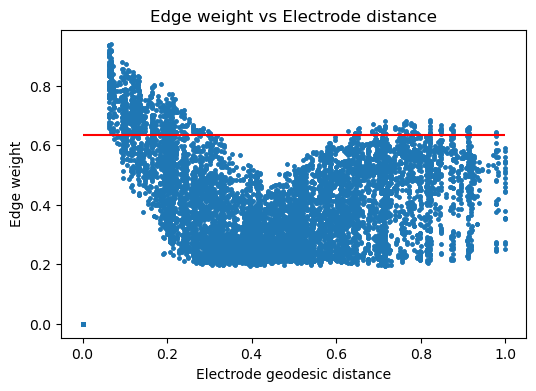

In [13]:
fig = plt.figure(figsize=(6,4))
plt.scatter(dist_geodesic.flatten(), A.mean(axis=0).flatten(), s=5)
plt.ylabel('Edge weight')
plt.xlabel('Electrode geodesic distance')
plt.title('Edge weight vs Electrode distance')
plt.hlines(np.mean(thresholds),xmin=0,xmax=1,colors='r')
plt.show()

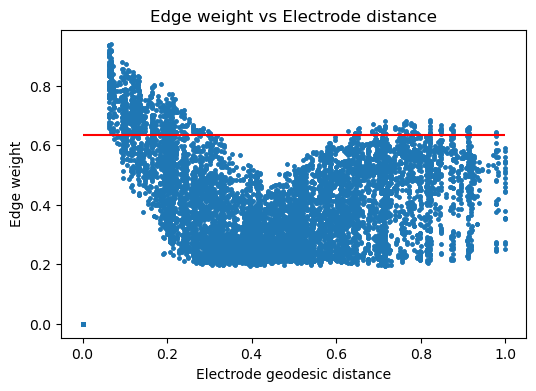

In [14]:
fig = plt.figure(figsize=(6,4))
plt.scatter(dist_geodesic.flatten(), A.mean(axis=0).flatten(), s=5)
plt.ylabel('Edge weight')
plt.xlabel('Electrode geodesic distance')
plt.title('Edge weight vs Electrode distance')
plt.hlines(np.mean(thresholds),xmin=0,xmax=1,colors='r')
plt.show()

In [15]:
fig.savefig('./figures/dist_corr_scatter.png')

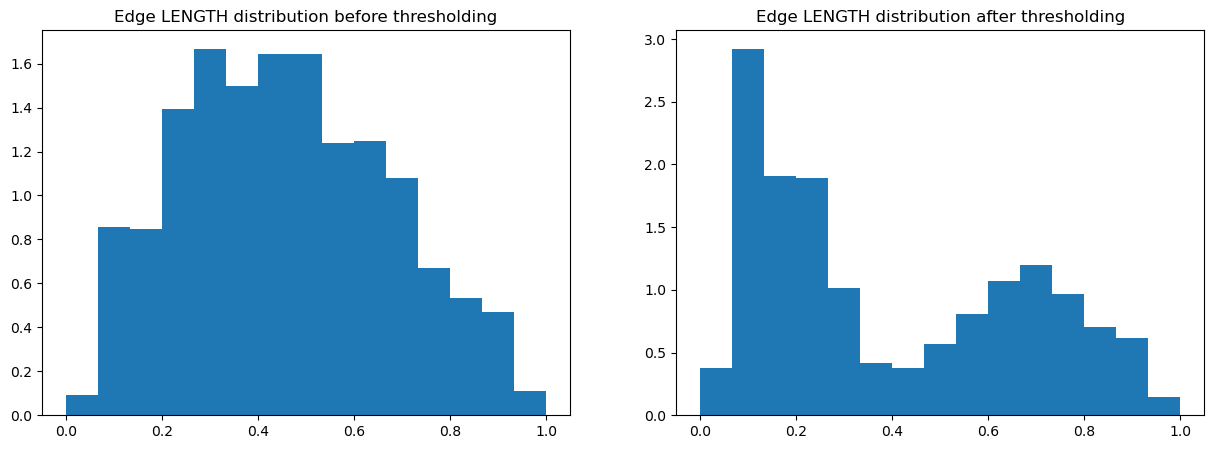

In [16]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].hist(dist_geodesic.flatten(), weights=A.astype(bool).sum(axis=0).flatten(), bins=15,density=True)
axs[0].set_title('Edge LENGTH distribution before thresholding')
axs[1].hist(dist_geodesic.flatten(), weights=A_thresh.astype(bool).sum(axis=0).flatten(), bins=15,density=True)
axs[1].set_title('Edge LENGTH distribution after thresholding')

plt.show()

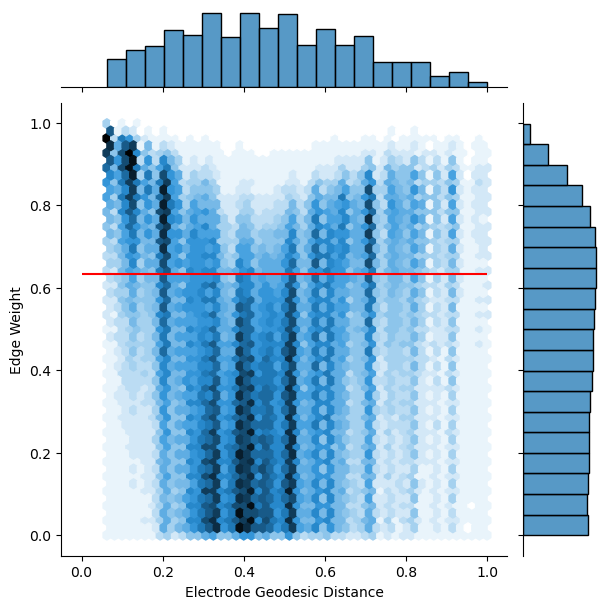

In [17]:
A_subset = A[:100]
dist_flat = np.broadcast_to(dist_geodesic, A_subset.shape).flatten()

n_bins = 20
sns.jointplot(x=dist_flat[dist_flat>0], y=A_subset.flatten()[A_subset.flatten()>0],kind='hex', bins=n_bins, marginal_kws=dict(bins=n_bins))
plt.hlines(np.mean(thresholds),xmin=0,xmax=1,colors='r')
plt.xlabel('Electrode Geodesic Distance')
plt.ylabel('Edge Weight')
plt.show()

## Take binary thresholded graph

In [18]:
A_bin = A_thresh.copy()
A_bin[A_bin!=0] = 1.
A_bin.shape

(10983, 128, 128)

In [19]:
# count cases of disconnected nodes
disc_graph_counts = 0
disc_nodes_counts = 0
for a in A_bin :
    d = a.sum(axis=0)
    disc_nodes_counts+=np.sum(d==0)
    disc_graph_counts+=np.any(d==0)

In [20]:
disc_nodes_counts/len(A_bin)

4.394791951197305

## Create Consensus Graph

In [21]:
def compute_consensus_graph(adjs_bin, density=.2):
    consensus = adjs_bin.sum(axis=0)
    threshold = ut.calculate_threshold(consensus, density)
    consensus[consensus<threshold]=0
    consensus[consensus!=0]=1
    return consensus

In [22]:
Concensus = compute_consensus_graph(A_bin)
Concensus.shape

(128, 128)

## Degree Distribution

In [23]:
D = A_bin.sum(axis=1)
D.shape

(10983, 128)

In [24]:
D_con = Concensus.sum(axis=-1)
D_con.shape

(128,)

Text(0.5, 1.0, 'Degree Distribution of Consensus Graph')

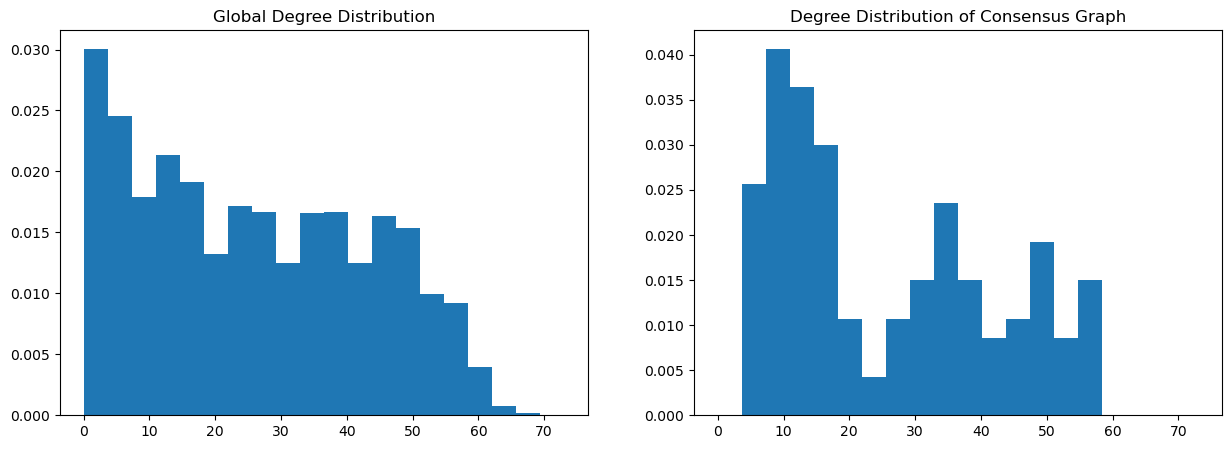

In [25]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
out1 = axs[0].hist(D.flatten(),bins=20,density=True)
axs[0].set_title('Global Degree Distribution')
axs[1].hist(D_con, bins=out1[1],density=True)
axs[1].set_title('Degree Distribution of Consensus Graph')

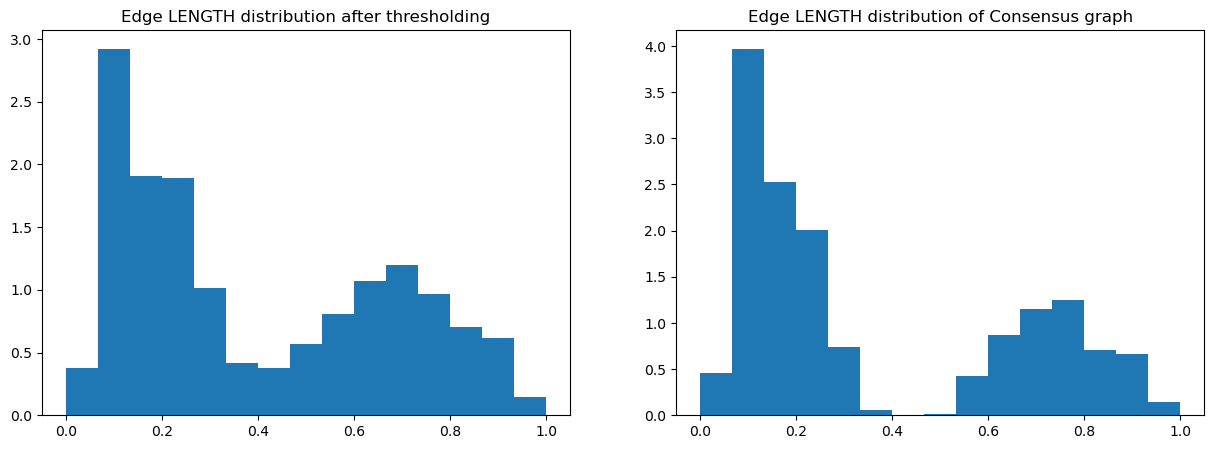

In [26]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].hist(dist_geodesic.flatten(), weights=A_bin.sum(axis=0).flatten(), bins=15,density=True)
axs[0].set_title('Edge LENGTH distribution after thresholding')
axs[1].hist(dist_geodesic.flatten(), weights=Concensus.flatten(), bins=15,density=True)
axs[1].set_title('Edge LENGTH distribution of Consensus graph')

plt.show()

### Fitting Curves to degree distribution

In [27]:
np.mean(D)

25.609375

In [28]:
from scipy.stats import poisson
from scipy.optimize import curve_fit
import warnings

warnings.filterwarnings('ignore')

# Sample degree distribution data
degrees = D.flatten()
N = len(degrees)

# Calculate the degree frequencies
unique_degrees, degree_counts = np.unique(degrees, return_counts=True)

# Normalize the degree distribution
#degree_probs = degree_counts / np.sum(degree_counts)
degree_probs = degree_counts

# Define the Poisson distribution function
def poisson_distribution(k, lambd):
    return N*poisson.pmf(k, lambd)

# my power law
def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

# exp law
def func_explaw(x, m, t, b):
    return m * np.exp(-t * x) + b

# Fit the Poisson distribution to the degree distribution
params, _ = curve_fit(poisson_distribution, unique_degrees, degree_probs)

# Fit the power law distribution to the degree distribution
powerlaw_params, _ = curve_fit(func_powerlaw, unique_degrees, degree_probs)

# Fit the exponential law distribution to the degree distribution
explaw_params, _ = curve_fit(func_explaw, unique_degrees, degree_probs, maxfev=20000)

# Generate x-values for the fitted Poisson and power law distribution curves
#x_values = np.arange(min(unique_degrees), max(unique_degrees) + 1)
x_values = np.arange(0, max(unique_degrees) + 1)

# Calculate the corresponding y-values using the fitted parameters
poisson_y_values = poisson_distribution(x_values, np.mean(degrees))
powerlaw_y_values = func_powerlaw(x_values, *powerlaw_params)
explaw_y_values = func_explaw(x_values, *explaw_params)

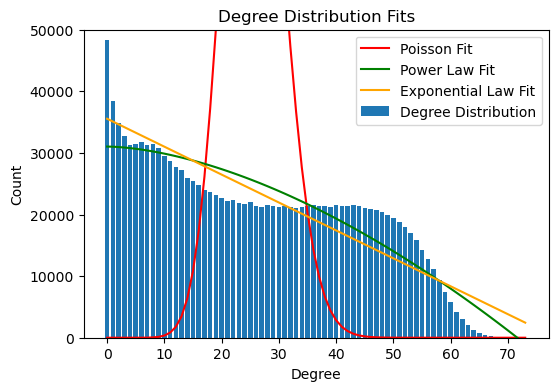

In [29]:

# Plot the original degree distribution and the fitted Poisson and power law distributions
fig = plt.figure(figsize=(6,4))
plt.bar(unique_degrees, degree_probs, label='Degree Distribution', alpha=1)
plt.plot(x_values, poisson_y_values, 'r-', label='Poisson Fit')
plt.plot(x_values, powerlaw_y_values, 'g-', label='Power Law Fit')
plt.plot(x_values, explaw_y_values, c='orange', label='Exponential Law Fit')

plt.ylim([0,50000])
plt.yscale('linear')
plt.xlabel('Degree')
plt.ylabel('Count')

plt.title('Degree Distribution Fits')
plt.legend()
plt.show()


In [30]:
fig.savefig('./figures/degree_distribution.png')


## Create Model Graphs to compare to

In [31]:
import networkx as  nx

### Check Giant Component

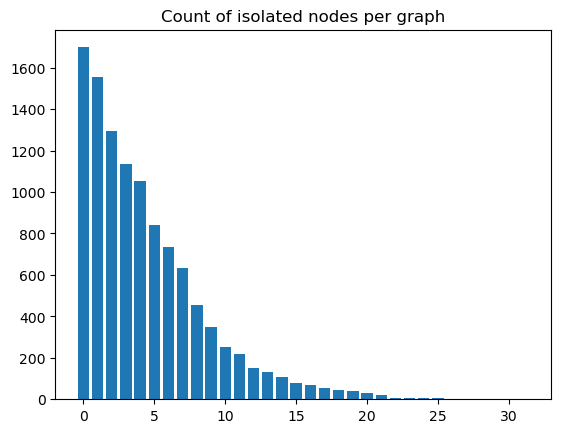

In [32]:
# Count proportion of graphs containing isolated nodes
unique_isol, isol_counts = np.unique(np.sum(D==0, axis=1), return_counts=True)
plt.bar(unique_isol, isol_counts)
plt.title('Count of isolated nodes per graph')
plt.show()

In [33]:
GC_n_nodes = []
for adj in A_bin :
    G = nx.from_numpy_array(adj)
    GC_n_nodes.append(len(max(nx.connected_components(G), key=len)))
GC_n_nodes= np.array(GC_n_nodes)

In [34]:
GC_n_nodes.mean()

121.97933169443685

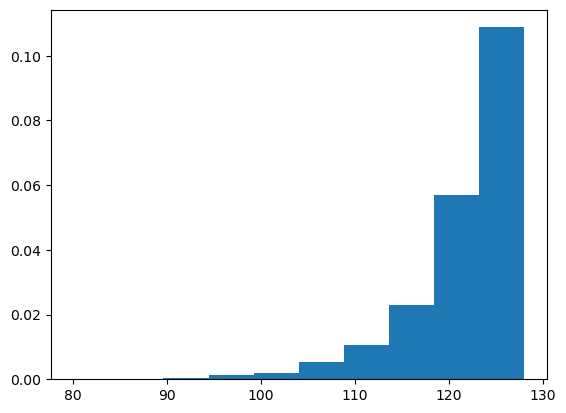

In [35]:
plt.hist(GC_n_nodes, density=True)
plt.show()

In [36]:
N_graphs = A_bin.shape[0]
N = A_bin.shape[1]
M = int(np.mean(A_bin.sum(axis=(1,2)))/2)
print("Number of links in each graph : {}".format(M))

Number of links in each graph : 1639


### Properties of our graphs

In [38]:
# We want the average clustering coeff and distance and diameter of our graphs
from multiprocessing import Pool
from tqdm.notebook import tqdm
CCs, SPLs, Diams, Size_gc = [], [], [], []
with Pool() as pool:
    for cc, spl, diam, n_gc in tqdm(pool.map(ut.compute_graph_stats, A_bin), total=len(A_bin)):
        CCs.append(cc)
        SPLs.append(spl)
        Diams.append(diam)
        Size_gc.append(n_gc)

  0%|          | 0/10983 [00:00<?, ?it/s]

In [39]:
print('Clustering Coeff : mean={:.2f}, std={:.2f}'.format(np.mean(CCs), np.std(CCs)))
print('Avg SPL : mean={:.2f}, std={:.2f}'.format(np.mean(SPLs), np.std(SPLs)))
print('Diameter : mean={:.2f}, std={:.2f}'.format(np.mean(Diams), np.std(Diams)))
print('Size of GC : mean={:.2f}, std={:.2f}'.format(np.mean(Size_gc), np.std(Size_gc)))



Clustering Coeff : mean=0.62, std=0.03
Avg SPL : mean=2.27, std=0.16
Diameter : mean=6.22, std=1.47
Size of GC : mean=121.98, std=6.09


In [40]:
# Erdos Renyi
p_er = 2*M/(N*(N-1))

G_er = nx.erdos_renyi_graph(N, p_er, seed=seed)

In [41]:
p_er

0.2016486220472441

In [42]:
# Watts-Strogatz
k_ws = np.round(2*M/N).astype(int)
p_ws = .01 # found using method in assigmnent 1b 

G_ws = nx.watts_strogatz_graph(N, k_ws, p_ws, seed=seed)

(array([ 1.,  0., 20.,  0.,  0., 87.,  0., 18.,  0.,  2.]),
 array([24. , 24.4, 24.8, 25.2, 25.6, 26. , 26.4, 26.8, 27.2, 27.6, 28. ]),
 <BarContainer object of 10 artists>)

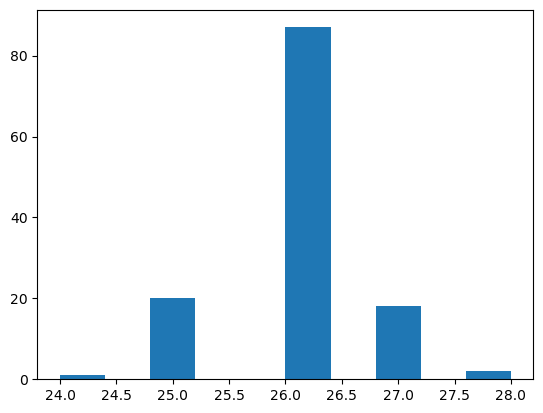

In [43]:
d_ws = list(d for n, d in G_ws.degree())
plt.hist(d_ws)

In [44]:
# Barabasi Albert
q_ba = round(M/N)

G_ba = nx.barabasi_albert_graph(N, q_ba)

In [45]:
for model, graph in zip(['ER','WS','BA'],[G_er, G_ws, G_ba]):
    print('Model : {}'.format(model))
    cc, spl, diam, n_gc = ut.compute_graph_stats(nx.to_numpy_array(graph))
    n_edges = graph.size()
    avg_deg = 2*n_edges/N
    print('N : {}, E : {}, GC: {}, avg_k : {:.2f}, spl :  {:.2f}, cc :  {:.2f}, diam : {}'.format(N, n_edges, n_gc,avg_deg, spl, cc, diam))


Model : ER
N : 128, E : 1605, GC: 128, avg_k : 25.08, spl :  1.81, cc :  0.20, diam : 3
Model : WS
N : 128, E : 1664, GC: 128, avg_k : 26.00, spl :  2.28, cc :  0.69, diam : 4
Model : BA
N : 128, E : 1495, GC: 128, avg_k : 23.36, spl :  1.84, cc :  0.30, diam : 3


(array([ 794., 3179., 3104., 2023., 1047.,  504.,  209.,   78.,   31.,
          14.]),
 array([ 3. ,  4.1,  5.2,  6.3,  7.4,  8.5,  9.6, 10.7, 11.8, 12.9, 14. ]),
 <BarContainer object of 10 artists>)

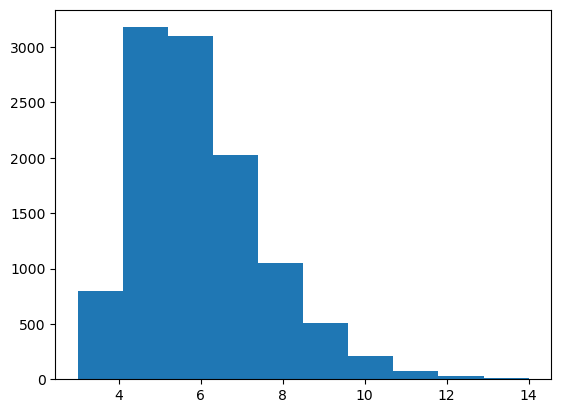

In [46]:
plt.hist(Diams)

# GSP

In [47]:
Concensus

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [48]:
import pygsp
from plotly import express as px
import pandas as pd

In [49]:
adj_struct = np.load('/Users/hugofluhr/Documents/Cours/NML/NetworkMachineLearning_2023/utils/electrodes_adj.npy')

In [50]:
G_cons = pygsp.graphs.Graph(A_thresh.mean(axis=0), lap_type='normalized')
G_cons.compute_fourier_basis()

In [51]:
fname = '../EEGDataset/electrode_coordinates.csv'
df = pd.read_csv(fname)

In [52]:
px.scatter_3d(df, x='x',y='y',z='z', color=G_cons.U[:,2])

In [53]:
px.scatter_3d(df, x='x',y='y',z='z', color=np.mean(D,axis=0))